In [1]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
import torch.nn as nn
import numpy as np

# - parameters
model_to_test = "models/covid_resnet18_e950_trained_full/model_e90.torch"
label_mapping = {0: "COVID", 1: "normal", 2: "pneumonia"}

# transformation
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

compose = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               normalize])


# init datasets
traindata = ImageFolder("COVIDNet_ImageFolder/train", transform=compose)
testdata = ImageFolder("COVIDNet_ImageFolder/test", transform=compose)
testdata_no_norm = ImageFolder("COVIDNet_ImageFolder/test", transform=transforms.Resize((224, 224)))
# init model and copy weights

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 3)
model.load_state_dict(torch.load(model_to_test))
target_layer = model.layer4[-1]
out_list = {}
for index in [4,269,367]:
    img, label = testdata[index]
    img = img.unsqueeze(0)
    cam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)
    target_category = label
    grayscale_cam = cam(input_tensor=img, target_category=target_category, eigen_smooth=True)
    grayscale_cam = grayscale_cam[0, :]
    orig_image, _  = testdata_no_norm[index]
    orig_image = np.array(orig_image)
    orig_image = np.float32(orig_image) / 255
    visualization = show_cam_on_image(orig_image, grayscale_cam)
    out_list[label] = visualization

/home/philipp/anaconda3/envs/aml_project/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


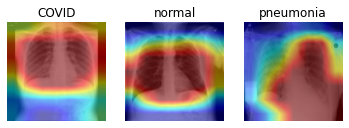

In [15]:
fig, axs = plt.subplots(1, 3)
for i, index in enumerate(out_list):
    img = out_list[i]
    axs[i].axis('off')
    axs[i].imshow(img)
    axs[i].set_title(f'{label_mapping[i]}')
plt.savefig("grad_cam.pdf", bbox_inches='tight')